## Imports

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(os.listdir("../movie_recommendation"))

['links_small.csv', 'links.csv', 'credits.csv', '.DS_Store', 'Untitled.ipynb', 'movies_metadata.csv', 'ratings.csv', '.ipynb_checkpoints', 'ratings_small.csv', 'keywords.csv']


## Variables

In [86]:
RARELY_RATED = 100
MOST_RATED_QUANTILE_CUTOFF = 0.95
CUTOFF_RATINGS = 0

## Load Data

In [4]:
# movies:
movie = pd.read_csv('../movie_recommendation/movies_metadata.csv')
movie.head(2)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [42]:
movie = movie.loc[:, ['id', 'title']]
movie['title_id'] = movie['title'] + '_' + movie['id'].astype(str)
movie.head()

,id,title,title_id
0,862,Toy Story,Toy Story_862
1,8844,Jumanji,Jumanji_8844
2,15602,Grumpier Old Men,Grumpier Old Men_15602
3,31357,Waiting to Exhale,Waiting to Exhale_31357
4,11862,Father of the Bride Part II,Father of the Bride Part II_11862


In [6]:
movie.describe()

,id,title
count,45466,45460
unique,45436,42277
top,141971,Cinderella
freq,3,11


## Data Pre-processing

In [7]:
# remove movies with no title
movie = movie.loc[~movie.title.isna()]
# remove movies with non-integer id
movie = movie[pd.to_numeric(movie['id'], errors='coerce').notnull()]
# convert movie id to numeric
movie.id = pd.to_numeric(movie['id'])
# remove duplicated rows
movie = movie[~movie['id'].isin(movie['id'][movie['id'].duplicated()])]

In [8]:
# movies with multiple ids
# note: some movies may have the same title but different ids - due to remake of the movie for exmaple
multi_id_movie = movie[movie['title'].isin(movie['title'][movie['title'].duplicated()])].sort_values("title")
multi_id_movie.title.value_counts()
multi_id_movie.head()

multi_id_movie['value_id'] = multi_id_movie.apply(lambda row : 
                                               min(list(multi_id_movie.loc[multi_id_movie.title == row.title, 'id'])),
                                               axis = 1)
multi_id_movie.head()


,id,title,value_id
42690,244046,10 Minutes,118658
24419,118658,10 Minutes,118658
1161,389,12 Angry Men,389
15200,12219,12 Angry Men,389
32777,27934,12 Chairs,27934


In [9]:
# ratings:
rating = pd.read_csv('../movie_recommendation/ratings.csv')
rating.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [10]:
rating = rating.loc[:,['userId', 'movieId', 'rating']]
rating.head(10)

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0
5,1,1968,4.0
6,1,2762,4.5
7,1,2918,5.0
8,1,2959,4.0
9,1,4226,4.0


In [11]:
data = pd.merge(movie, rating, left_on='id', right_on='movieId')
# data['title_id'] = data['title'] + '_' + data['id'].astype(str)
data.head(10)

,id,title,userId,movieId,rating,title_id
0,862,Toy Story,1923,862,3.0,Toy Story_862
1,862,Toy Story,2103,862,5.0,Toy Story_862
2,862,Toy Story,5380,862,1.0,Toy Story_862
3,862,Toy Story,6177,862,4.0,Toy Story_862
4,862,Toy Story,6525,862,4.0,Toy Story_862
5,862,Toy Story,7050,862,3.0,Toy Story_862
6,862,Toy Story,7238,862,3.0,Toy Story_862
7,862,Toy Story,8659,862,4.0,Toy Story_862
8,862,Toy Story,9328,862,4.0,Toy Story_862
9,862,Toy Story,9682,862,4.0,Toy Story_862


## Data Exploration

In [12]:
print(data.shape)
data.describe().transpose()

(11435499, 6)


,count,mean,std,min,25%,50%,75%,max
id,11435499.0,7087.044822,18260.267173,2.0,500.0,1410.0,3033.0,176273.0
userId,11435499.0,135116.491896,78123.065470,1.0,67397.0,135418.0,202693.0,270896.0
movieId,11435499.0,7087.044822,18260.267173,2.0,500.0,1410.0,3033.0,176273.0
rating,11435499.0,3.532718,1.066917,0.5,3.0,4.0,4.0,5.0


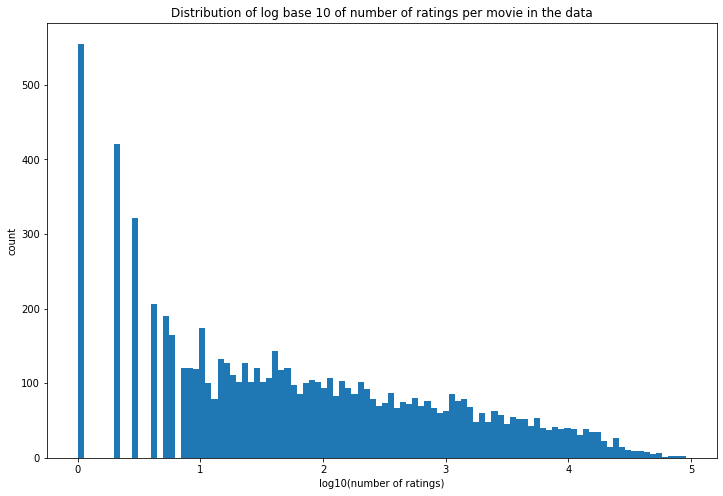

In [13]:
# QUANTILE = 3
CUTOFF_RATINGS = 0

# movie_rating_counts = data.title_after_agg.value_counts()
# RARELY_RATYED_CUTOFF = np.quantile(movie_rating_counts, [x / 10 for x in range(0, 11, 1)])[QUANTILE]

# data['title_after_agg'] = data['title_id']

# rare_movie = (data['title_id'].value_counts()[data['title_id'].value_counts()\
#                                                           < RARELY_RATYED_CUTOFF]).index

# data.loc[data['title_id'].isin(rare_movie), 'title_after_agg'] = 'other'

count_ratings = data['title_id'].value_counts()
more_than_cutoff = count_ratings[count_ratings > CUTOFF_RATINGS].index

more_than_cutoff_ratings = data.loc[data['title_id'].isin(more_than_cutoff), :]

log_more_than_cutoff_ratings = np.log10(more_than_cutoff_ratings['title_id'].value_counts())

fig = plt.figure(figsize=(12,8))
plt.hist(log_more_than_cutoff_ratings, bins=100)
plt.ylabel('count')
plt.xlabel('log10(number of ratings)')
plt.title('Distribution of log base 10 of number of ratings per movie in the data')
plt.show()

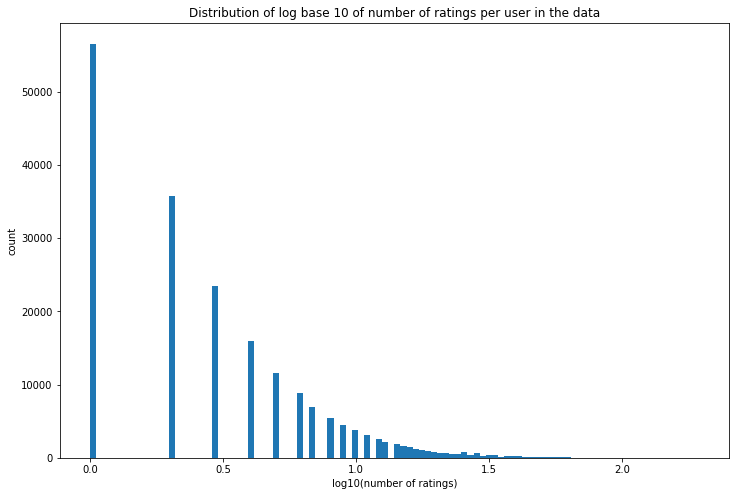

In [18]:
data.head()

count_ratings_per_user = data['userId'].value_counts()
more_than_cutoff = count_ratings_per_user[count_ratings_per_user > CUTOFF_RATINGS].index

more_than_cutoff_ratings = data.loc[data['userId'].isin(more_than_cutoff), :]

log_more_than_cutoff_ratings = np.log10(more_than_cutoff_ratings['userId'].value_counts())

fig = plt.figure(figsize=(12,8))
plt.hist(log_more_than_cutoff_ratings, bins=100)
plt.ylabel('count')
plt.xlabel('log10(number of ratings)')
plt.title('Distribution of log base 10 of number of ratings per user in the data')
plt.show()

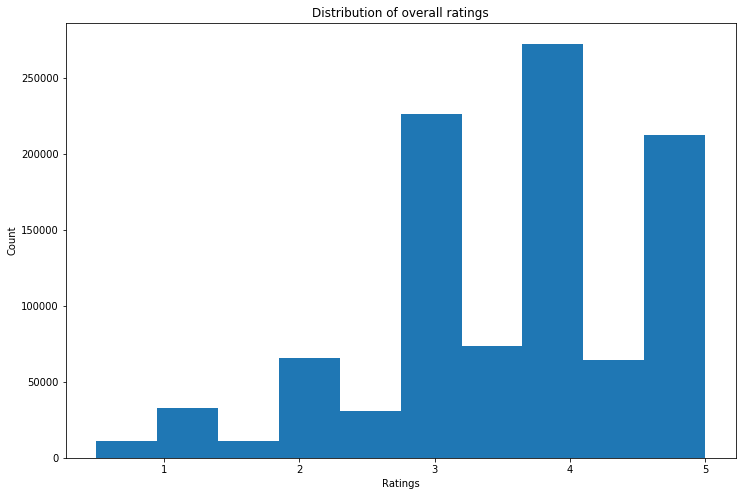

In [37]:
fig = plt.figure(figsize=(12,8))
plt.hist(data['rating'])
plt.ylabel('Count')
plt.xlabel('Ratings')
plt.title('Distribution of overall ratings')
plt.show()

In [137]:
# cut to smaller dataset for processing time
data = data.iloc[:1000000,]
data.head()

,id,title,userId,movieId,rating,title_id
0,862,Toy Story,1923,862,3.0,Toy Story_862
1,862,Toy Story,2103,862,5.0,Toy Story_862
2,862,Toy Story,5380,862,1.0,Toy Story_862
3,862,Toy Story,6177,862,4.0,Toy Story_862
4,862,Toy Story,6525,862,4.0,Toy Story_862


In [16]:
pivot_table = data.pivot_table(index = ['userId'], columns = ['title_id'], values = 'rating')
pivot_table.head(10)

title_id,"20,000 Leagues Under the Sea_173",2001: A Space Odyssey_62,A Close Shave_532,A Fish Called Wanda_623,A Great Day in Harlem_124472,A Pyromaniac's Love Story_2307,A Time to Kill_1645,Ace Ventura: Pet Detective_3049,Across the Sea of Time_139405,Addams Family Values_2758,...,Two Deaths_124645,Under Siege 2: Dark Territory_3512,Unforgettable_2045,Vertigo_426,What's Eating Gilbert Grape_1587,When Night Is Falling_8391,While You Were Sleeping_2064,Wild Bill_65796,Wild Reeds_26933,Willy Wonka & the Chocolate Factory_252
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,4.0,NaN,NaN,NaN


## 1) Baseline Model - Item-based collaborative filtering given a liked movie based on correlation between movies' rating

In [33]:
def provide_basic_recommendation(movie_you_watched_and_liked):
    
    watched = pivot_table[movie_you_watched_and_liked]
    
    num_ranking_for_watched = watched.notna().sum()
    
    print('The movie ' + movie_you_watched_and_liked + ' was ranked ' + str(num_ranking_for_watched) + ' times.')
    print('')
    
    similar_movies = pivot_table.corrwith(watched).sort_values(ascending=False)
    similar_movies = similar_movies.drop(movie_you_watched_and_liked)
    
    print('If you\'ve liked ' + movie_you_watched_and_liked + ', these are a few movies you might also like:')
    print('')
    print(similar_movies[0:15])
    print('')
    
    return
    
provide_basic_recommendation('A Fish Called Wanda_623')
provide_basic_recommendation('Toy Story_862')

The movie A Fish Called Wanda_623 was ranked 46 times.

If you've liked A Fish Called Wanda_623, these are a few movies you might also like:

title_id
Malice_2246                                                                 1.000000
Ransom_3595                                                                 1.000000
Outbreak_6950                                                               1.000000
Rear Window_567                                                             1.000000
Poetic Justice_8291                                                         1.000000
A Pyromaniac's Love Story_2307                                              1.000000
The Maltese Falcon_963                                                      1.000000
Nick of Time_2086                                                           1.000000
Pather Panchali_5801                                                        0.981981
Reservoir Dogs_500                                                          0.970725

## 2) Demographic Filtering - Average Audience Preferences

Using this approach, the goal is to achieve the overall most liked movies, taking into account both the overall rating and overall number of votes per movie.

##### Weighted Rating = 
##### (#votes / (#votes + min_required_votes)) * avg_rating for movie + ((min_required_votes / #votes + min_required_votes) * overall_avg_vote)

In [38]:
overall_avg_vote = data['rating'].mean()
overall_avg_vote

3.6407865

In [49]:
movie['average_rating'] = movie.apply(lambda row: rating.loc[rating.movieId == row.id, 'rating'].mean(), axis=1)

In [50]:
movie['number_raters'] = movie.apply(lambda row: len(rating.loc[rating.movieId == row.id, 'rating']), axis=1)

In [87]:
min_required_votes = movie['number_raters'].quantile(MOST_RATED_QUANTILE_CUTOFF)
min_required_votes

261.0

In [88]:
movie_q = movie.copy().loc[movie.number_raters >= min_required_votes]
print(movie_q.shape)
movie_q.head()

(2272, 5)


,id,title,title_id,average_rating,number_raters
0,862,Toy Story,Toy Story_862,3.598930,374
5,949,Heat,Heat_949,3.905544,2345
9,710,GoldenEye,GoldenEye_710,2.740334,1319
14,1408,Cutthroat Island,Cutthroat Island_1408,3.710181,13888
15,524,Casino,Casino_524,3.515170,9163


In [95]:
# calculate weighted rating:
def weighted_rating(row, min_required_votes=min_required_votes, overall_average=overall_avg_vote):
    num_raters = row['number_raters']
    average_rate = row['average_rating']
    denominator = num_raters + min_required_votes
    # calculate weighted rating:
    return ((num_raters / denominator) * average_rate) + ((min_required_votes / denominator) * overall_average)

In [96]:
movie_q['wr'] = movie_q.apply(weighted_rating, axis=1)

In [98]:
movie_q = movie_q.sort_values('wr', ascending=False)
movie_q.head(15)

,id,title,title_id,average_rating,number_raters,wr
4020,318,The Million Dollar Hotel,The Million Dollar Hotel_318,4.429015,91082,4.426762
534,858,Sleepless in Seattle,Sleepless in Seattle_858,4.339811,57070,4.336628
286,527,Once Were Warriors,Once Were Warriors_527,4.266531,67662,4.264126
459,2019,Hard Target,Hard Target_2019,4.255074,13994,4.243826
11922,2959,License to Wed,License to Wed_2959,4.230716,60024,4.228162
2649,912,The Thomas Crown Affair,The Thomas Crown Affair_912,4.214393,30043,4.209452
8546,750,Murder She Said,Murder She Said_750,4.213030,28280,4.207797
8737,5618,"Cousin, Cousine","Cousin, Cousine_5618",4.202589,20855,4.195645
17046,44555,"A Woman, a Gun and a Noodle Shop","A Woman, a Gun and a Noodle Shop_44555",4.199039,8948,4.183217
700,922,Dead Man,Dead Man_922,4.200820,7930,4.182975


In [112]:
movie.loc[movie.title == 'Pulp Fiction',:]
# rating.loc[rating.movieId == 680, 'rating'].mean()

,id,title,title_id,average_rating,number_raters
292,680,Pulp Fiction,Pulp Fiction_680,3.55297,1246


In [85]:
count_ratings.quantile(0.9)

3           5.0
65          5.0
758         4.0
1398        3.5
1860        5.0
           ... 
26019967    3.5
26020385    0.5
26020876    5.0
26021231    1.0
26023901    1.5
Name: rating, Length: 36679, dtype: float64

In [43]:
rating.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [81]:
movie.head()

,id,title,title_id,average_rating,number_raters
0,862,Toy Story,Toy Story_862,3.598930,374
1,8844,Jumanji,Jumanji_8844,3.760163,123
2,15602,Grumpier Old Men,Grumpier Old Men_15602,NaN,0
3,31357,Waiting to Exhale,Waiting to Exhale_31357,NaN,0
4,11862,Father of the Bride Part II,Father of the Bride Part II_11862,NaN,0


## Trending movies - Based on pupularity measures:

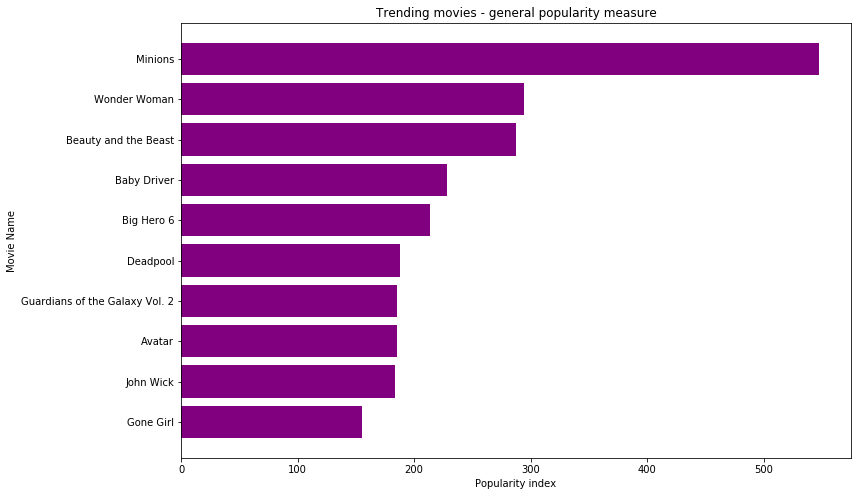

In [136]:
original_movie = pd.read_csv('../movie_recommendation/movies_metadata.csv')
# original_movie.loc[:,'popularity'].unique()
# original_movie.columns

original_movie = original_movie[pd.to_numeric(original_movie['popularity'], errors='coerce').notnull()]
# convert movie id to numeric
original_movie.popularity = pd.to_numeric(original_movie['popularity'])

popular = original_movie.loc[:, ['id', 'title', 'popularity']].sort_values('popularity', ascending=False)

fig = plt.figure(figsize=(12,8))
plt.barh(popular['title'].head(10), popular['popularity'].head(10), color='purple')
plt.gca().invert_yaxis()
plt.ylabel('Movie Name')
plt.xlabel('Popularity index')
plt.title('Trending movies - general popularity measure')
plt.show()

## Content-based Recommender System

## Feature Engineering

## Model